In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.float_format', lambda x: '%.3f' % x)

---
##### CLTV Prediction = Probabilistic lifetime value estimation with time projection
---

In [2]:
df_ = pd.read_csv("flo_data_20k.csv", encoding='utf-8')
df = df_.copy()

In [3]:
def quick_info(dataframe):
    print("--------- HEAD ---------")
    print(dataframe.head(10))
    print("--------- SHAPE ---------")
    print(dataframe.shape)
    print("--------- COLUMNS ---------")
    print(dataframe.columns)
    print("--------- DESCRIBE ---------")
    print(dataframe.describe().T)
    print("--------- INFO ---------")
    print(dataframe.info())
    print("--------- FREQUENCY ---------")
    print(dataframe.nunique())
    print("--------- ANY NULL VALUES ---------")
    print(dataframe.isnull().values.any())
    print("--------- SUM OF NULL VALUES ---------")
    print(dataframe.isnull().sum())

quick_info(df)

--------- HEAD ---------
                              master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App        Android App   
3  1854e56c-491f-11eb-806e-000d3a38a36f   Android App        Android App   
4  d6ea1074-f1f5-11e9-9346-000d3a38a36f       Desktop            Desktop   
5  e585280e-aae1-11e9-a2fc-000d3a38a36f       Desktop            Offline   
6  c445e4ee-6242-11ea-9d1a-000d3a38a36f   Android App        Android App   
7  3f1b4dc8-8a7d-11ea-8ec0-000d3a38a36f        Mobile            Offline   
8  cfbda69e-5b4f-11ea-aca7-000d3a38a36f   Android App        Android App   
9  1143f032-440d-11ea-8b43-000d3a38a36f        Mobile             Mobile   

  first_order_date last_order_date last_order_date_online  \
0       2020-10-30      2021-02-26             2021-02-21   
1       2017-02-

In [4]:
# It will enable us to take the necessary actions to suppress the outliers in the data set.

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1

    upper_limit = quartile3 + 1.5 * interquantile_range
    lower_limit = quartile1 - 1.5 * interquantile_range
    return lower_limit, upper_limit

def replace_with_thresholds(dataframe, variable):
    lower_limit, upper_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > upper_limit), variable] = round(upper_limit)
    dataframe.loc[(dataframe[variable] < lower_limit), variable] = round(lower_limit)

In [5]:
check_outlier_values = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online"]

def check_outlier(dataframe, col_name):
    lower_limit, upper_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] > upper_limit) > upper_limit) | (dataframe[col_name] < lower_limit)].any(axis=None):
        return True
    else:
        return False

for col in check_outlier_values:
    print(col, check_outlier(df,col))
    replace_with_thresholds(df, col)

order_num_total_ever_online False
order_num_total_ever_offline False
customer_value_total_ever_offline False
customer_value_total_ever_online False


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.000,3.092,3.810,1.000,1.000,2.000,4.000,48.000
order_num_total_ever_offline,19945.000,1.886,1.435,1.000,1.000,1.000,2.000,16.000
customer_value_total_ever_offline,19945.000,251.921,251.024,10.000,99.990,179.980,319.970,3020.000
customer_value_total_ever_online,19945.000,489.706,632.610,12.990,149.980,286.460,578.440,7800.000


In [7]:
#The number of orders and expenses made by customers both online and offline were combined
df['order_num_total'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline'] #Orders (frequency)
df['customer_value_total'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline'] #Expenses (monetary)

In [8]:
# Current dtype is 'object' and format is yy-mm-dd
date_cols = df.columns[df.columns.str.contains('date')]
# Converted to date type
df[date_cols] = df[date_cols].apply(pd.to_datetime)

In [9]:
df[date_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_date         19945 non-null  datetime64[ns]
 1   last_order_date          19945 non-null  datetime64[ns]
 2   last_order_date_online   19945 non-null  datetime64[ns]
 3   last_order_date_offline  19945 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 623.4 KB


In [10]:
# Return the latest order in the dataset, required to determine analysis date
latest_order_date = df['last_order_date'].max()
latest_order_date

Timestamp('2021-05-30 00:00:00')

In [11]:
# Allowed to select the analysis date 2 days after the maximum date to calculate the recency value
analysis_date = latest_order_date + timedelta(days=2)

*RECALL*

---

**Recency**: How many weeks customer was the customer when he/she made the last purchase? (Last purchase date - First purchase date)
**T - Tenur**: Customer's age (In weeks) (Analysis date - First purchase date)
**Frequency**: Total number of purchases, ie how many times the customer came (Must be greater than 1)
**Monetary**: Average earnings per purchase

In [12]:
# Create a new dataframe called cltv_df, contains master_id, recency_cltv_weekly, T_weekly, frequency, monetary_cltv_avg
cltv_df = pd.DataFrame()

cltv_df["master_id"] = df["master_id"]
cltv_df["recency_cltv_weekly"] = ((df["last_order_date"]- df["first_order_date"]).astype('timedelta64[D]')) / 7 # Divided by 7 to set as weekly
cltv_df["T_weekly"] = (analysis_date - df["first_order_date"]).dt.days / 7 # Divide by 7 to adjust weekly
cltv_df["frequency"] = df["order_num_total"]
cltv_df["monetary_cltv_avg"] = df["customer_value_total"] / df["order_num_total"]

In [13]:
cltv_df

,master_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990
...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.143,88.429,3.000,133.987
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.286,65.286,2.000,195.235
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.714,89.857,3.000,210.980
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.429,113.857,6.000,168.295


In [14]:
# Rename column names
cltv_df.columns = ['master_id', 'recency', 'T', 'frequency', 'monetary']

In [15]:
cltv_df

,master_id,recency,T,frequency,monetary
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990
...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.143,88.429,3.000,133.987
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.286,65.286,2.000,195.235
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.714,89.857,3.000,210.980
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.429,113.857,6.000,168.295


*RECALL*

---

**BG-NBD Model**    --- _returns_ --->    Expected Number of Transaction
**Gamma-Gamma Submodel**    --- _returns_ --->    Expected Average Profit

In [16]:
bg_model = BetaGeoFitter(penalizer_coef=0.01) # Define BG-NBD model

bg_model.fit(cltv_df['frequency'], cltv_df['recency'], cltv_df['T']) # Fit a dataset to the BG/NBD model

/home/nedim/Documents/DSMLBC10/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 48.87, b: 0.00, r: 2.39>

In [17]:
# 3 months prediction
bg_model.predict(12, cltv_df['frequency'], cltv_df['recency'], cltv_df['T']) # Make predictions with given time period and dataset

0       1.117
1       1.026
2       0.695
3       0.756
4       0.365
         ... 
19940   0.471
19941   0.462
19942   0.467
19943   0.619
19944   0.377
Length: 19945, dtype: float64

In [18]:
# Assign 3 months prediction to the dataset
cltv_df['exp_sales_3_month'] = bg_model.predict(12, cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

In [19]:
# 6 months prediction
bg_model.predict(24, cltv_df['frequency'], cltv_df['recency'], cltv_df['T']) # Make predictions with given time period and dataset

0       2.234
1       2.051
2       1.389
3       1.512
4       0.731
         ... 
19940   0.943
19941   0.924
19942   0.933
19943   1.238
19944   0.754
Length: 19945, dtype: float64

In [20]:
# Assign 6 months prediction to the dataset
cltv_df['exp_sales_6_month'] = bg_model.predict(24, cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

In [21]:
cltv_df

,master_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,1.117,2.234
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883,1.026,2.051
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.695,1.389
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.756,1.512
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.365,0.731
...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.143,88.429,3.000,133.987,0.471,0.943
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.286,65.286,2.000,195.235,0.462,0.924
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.714,89.857,3.000,210.980,0.467,0.933
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.429,113.857,6.000,168.295,0.619,1.238


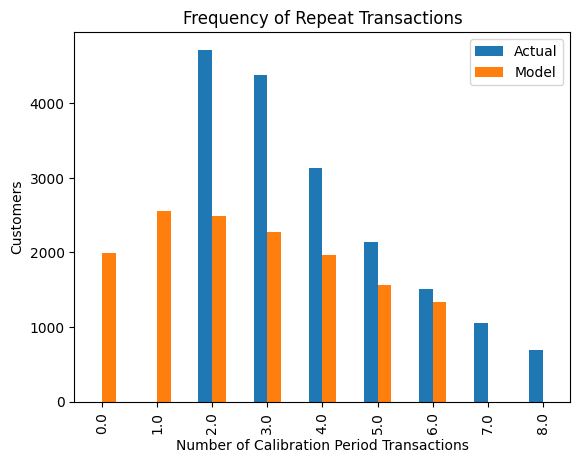

In [22]:
#Visualization of the model
plot_period_transactions(bg_model)
plt.show()

In [23]:
gg_model = GammaGammaFitter(penalizer_coef=0.01) # Define gamma-gamma model

gg_model.fit(cltv_df['frequency'], cltv_df['monetary'])  # Fit a dataset to the gamma-gamma model

gg_model.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary']) # Make predictions with given dataset

0       193.633
1        96.665
2       120.968
3        67.320
4       114.325
          ...  
19940   141.360
19941   210.722
19942   221.775
19943   172.647
19944   142.092
Length: 19945, dtype: float64

In [24]:
# Predict expected average profit of the customers
gg_model.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary'])

0       193.633
1        96.665
2       120.968
3        67.320
4       114.325
          ...  
19940   141.360
19941   210.722
19942   221.775
19943   172.647
19944   142.092
Length: 19945, dtype: float64

In [25]:
# Assign predicted expected average profit of the customers to the dataset
cltv_df["exp_average_value"] = gg_model.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary'])

In [26]:
cltv_df

,master_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,1.117,2.234,193.633
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883,1.026,2.051,96.665
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.695,1.389,120.968
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.756,1.512,67.320
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.365,0.731,114.325
...,...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.143,88.429,3.000,133.987,0.471,0.943,141.360
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.286,65.286,2.000,195.235,0.462,0.924,210.722
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.714,89.857,3.000,210.980,0.467,0.933,221.775
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.429,113.857,6.000,168.295,0.619,1.238,172.647


In [27]:
# Calculate Customer Lifetime Value (CLTV)
gg_model.customer_lifetime_value(transaction_prediction_model=bg_model,
                                 frequency=cltv_df['frequency'],
                                 recency=cltv_df["recency"],
                                 T=cltv_df["T"],
                                 monetary_value=cltv_df["monetary"],
                                 time=24,
                                 freq="W")

0       1663.512
1        762.554
2        646.382
3        391.590
4        321.353
          ...   
19940    512.633
19941    748.707
19942    795.970
19943    822.040
19944    412.048
Name: clv, Length: 19945, dtype: float64

In [28]:
# Assign calculated Customer Lifetime Value (CLTV) to the dataset
cltv_df['cltv'] = gg_model.customer_lifetime_value(transaction_prediction_model=bg_model,
                                                   frequency=cltv_df['frequency'],
                                                   recency=cltv_df["recency"],
                                                   T=cltv_df["T"],
                                                   monetary_value=cltv_df["monetary"],
                                                   time=24,
                                                   freq="W")

In [29]:
cltv_df

,master_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,1.117,2.234,193.633,1663.512
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883,1.026,2.051,96.665,762.554
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.695,1.389,120.968,646.382
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.756,1.512,67.320,391.590
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.365,0.731,114.325,321.353
...,...,...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.143,88.429,3.000,133.987,0.471,0.943,141.360,512.633
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.286,65.286,2.000,195.235,0.462,0.924,210.722,748.707
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.714,89.857,3.000,210.980,0.467,0.933,221.775,795.970
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.429,113.857,6.000,168.295,0.619,1.238,172.647,822.040


In [30]:
# Observe the top 20 customers with the highest CLTV value
cltv_df.sort_values(by='cltv', ascending=False).head(20)

,master_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.143,13.143,11.000,758.085,2.592,5.184,767.361,15297.669
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857,7.857,4.000,1401.800,1.353,2.705,1449.060,15075.706
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714,13.000,17.000,259.865,3.761,7.523,262.073,7582.323
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714,67.286,52.000,166.225,5.619,11.239,166.712,7205.744
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.429,34.429,8.000,601.226,1.497,2.995,611.493,7042.798
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.286,74.571,16.000,501.874,1.788,3.576,506.167,6961.731
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.571,58.714,31.000,228.530,3.725,7.449,229.607,6578.189
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.714,101.000,7.000,1106.467,0.752,1.504,1127.612,6524.031
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.286,9.429,2.000,862.690,0.904,1.809,923.680,6426.094
10876,ae149d98-9b6a-11eb-9c47-000d3a38a36f,6.143,7.143,9.000,317.484,2.441,4.882,322.512,6055.224


In [31]:
# Divide CLTV values into segments with qcut & assigned to new columns
cltv_df['segment'] = pd.qcut(cltv_df['cltv'], 4, labels=["D","C","B","A"])

In [32]:
cltv_df.loc[:, ['master_id', 'cltv', 'segment']]

,master_id,cltv,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,1663.512,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,762.554,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,646.382,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,391.590,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,321.353,D
...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,512.633,C
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,748.707,B
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,795.970,B
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,822.040,B


In [33]:
# CLTV value is analyzed on a segment basis according to certain parameters
cltv_df.groupby("segment").agg({'cltv':["count", "mean", "sum"]})

cltv                     
        count     mean         sum
segment                           
D        4987  278.899 1390867.622
C        4986  498.064 2483347.281
B        4986  736.589 3672632.478
A        4986 1409.530 7027915.093

### Action Case

Make short 6-month action suggestions to the management for 2 groups that you will choose from among 4 groups.

In [34]:
# TO DO